## Basics

In [ ]:
def get_results_for_p(p,all_results):
    # Create the key as a tuple
    #key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.k_entry,p.k_f,p.prod_alpha,p.dt)
    key = (p.num_z,p.num_v,p.z_corr,p.prod_var_z,p.num_q,p.q_0,p.prod_q,p.s_job,p.alpha,p.kappa,p.dt,p.u_bf_m,p.min_wage)
    # Check if the key exists in the saved results
    if key in all_results:
        print(key)
        return all_results[key]
    else:
        print(f"No results found for p = {key}")
        return None
new_baseline = {
   'q_0': 0.56602, 'prod_q':	0.50425,'u_bf_m':	2.34264/4,'s_job':	0.779616,'alpha':	0.79,'z_corr':	0.946006,'prod_var_z':	0.646317
}
another_baseline = { #This shit aint even solvable??? wtf?
'q_0':     0.7094052599792449,
'prod_q':    0.48553336143372877,
'u_bf_m':    0.5884034329521419,
's_job':    0.35319166225985643,
'alpha':    0.15424752943946796,
'z_corr':    0.8809848371620363,
'prod_var_z':    0.6063338243114458
}
from primitives import Parameters
p = Parameters(overwrite=another_baseline)
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
import cProfile
import pstats
plts=Plots(p)

In [ ]:
# Load the temp objects

#with open("results_GE.pkl", "rb") as file:
#    all_results = pickle.load(file)
#results_GE = get_results_for_p(p,all_results)


with open("model_GE.pkl", "rb") as file:
    all_results = pickle.load(file)
model = get_results_for_p(p,all_results)
if model is None:
    import numpy as np
    ax = np.newaxis
    #from Multiworker_Contract_GE_JITted import MultiworkerContract
    from CRS_HMQ_full import MultiworkerContract
    mwc_J=MultiworkerContract(p)
    model=mwc_J.J_sep(update_eq=1,s=0)

In [ ]:
from CRS_HMQ_full import MultiworkerContract
mwc_J=MultiworkerContract(p)
model=mwc_J.J_sep(update_eq=1,s=0)

In [ ]:
from simulate import Simulator
sim = Simulator(model,p)
moms_mean,_,moms_unt_mean,_ = sim.simulate_moments_rep(5)
moms_mean

(5, 200, 0.95, 0.14, 6, 0.7, 0.3, 0.65, 1.0, 0.25, 2.0, 2.0) best so far: good with the transition rates (j2j and u2e slightly small, but not horrible), but the productivity moments are crazy small???? did I do them wrong? although in the BL ones are kinda crazy...

(5, 200, 0.95, 0.14, 6, 0.8, 0.4, 0.65, 1.0, 0.25, 0.5, 0.5) was good with j2j, but bad with layoffs

In [ ]:
#Moments comparison:
E2U annual: 1-(1-0.004116)**4 # soo this is a 1.6% layoff rate, tooo low
J2j annual: 1- (1 - 0.036997)**4 #14% j2j rate, way too high
Pr_new hire: 4% compared to 13% in the data #soooooo need to raise the pr_u2e even firther??? 49% aint enough? BL had 17% QUARTERLY transition probability
#Maybe this should be checked using annual data? Maybe pr_new_hire dooes not translate perfectly between quarterly and annual? hmmmm I'd guess so? 

0.13997602111275775

In [6]:
moms_unt_mean['autocov_ypw_alt']['ypw_l4']

np.float64(0.6972788225321755)

In [5]:
moms_unt_mean['wage_pass_ten']#['C(tenure)[T.15.0]:dypw']

coef
Intercept                0.260714
dypw                    -0.029017
C(tenure)[T.1.0]        -0.234174
C(tenure)[T.2.0]        -0.265843
C(tenure)[T.3.0]        -0.265482
C(tenure)[T.4.0]        -0.265506
C(tenure)[T.5.0]        -0.264684
C(tenure)[T.6.0]        -0.264581
C(tenure)[T.7.0]        -0.264694
C(tenure)[T.8.0]        -0.264646
C(tenure)[T.9.0]        -0.264740
C(tenure)[T.1.0]:dypw    0.042506
C(tenure)[T.2.0]:dypw    0.038396
C(tenure)[T.3.0]:dypw    0.048169
C(tenure)[T.4.0]:dypw    0.048103
C(tenure)[T.5.0]:dypw    0.049450
C(tenure)[T.6.0]:dypw    0.050814
C(tenure)[T.7.0]:dypw    0.049641
C(tenure)[T.8.0]:dypw    0.049506
C(tenure)[T.9.0]:dypw    0.051323
Name: regressions_mean, dtype: float64

In [15]:
moms_unt_mean['sep_ten']

coef
Intercept           0.043607
C(tenure)[T.1.0]   -0.035763
C(tenure)[T.2.0]   -0.042548
C(tenure)[T.3.0]   -0.043351
C(tenure)[T.4.0]   -0.043553
C(tenure)[T.5.0]   -0.043570
C(tenure)[T.6.0]   -0.043607
C(tenure)[T.7.0]   -0.043607
C(tenure)[T.8.0]   -0.043607
C(tenure)[T.9.0]   -0.043607
Name: regressions_mean, dtype: float64

In [ ]:
import sqlite3
import pandas as pd

db_path = "runs/quickscan/eval_log.sqlite"

# Read-only connection (works even while the optimizer is writing)
con = sqlite3.connect(f"file:{db_path}?mode=ro", uri=True, timeout=5)

# Peek at the schema
print(pd.read_sql_query("PRAGMA table_info(eval_log);", con))

# How many evaluations so far?
n = pd.read_sql_query("SELECT COUNT(*) AS n FROM eval_log;", con).iloc[0,0]
print("rows logged:", n)

tail = pd.read_sql_query("""
  SELECT id, ts, obj
  FROM eval_log
  ORDER BY id DESC
  LIMIT 10;
""", con)
tail

best = pd.read_sql_query("""
  SELECT *
  FROM eval_log
  ORDER BY obj ASC
  LIMIT 1;
""", con)
best

In [6]:
model.Vf_W.min()


np.float64(39.634454607396236)

In [13]:
model.Vf_U

np.float64(-8.893649214830631)

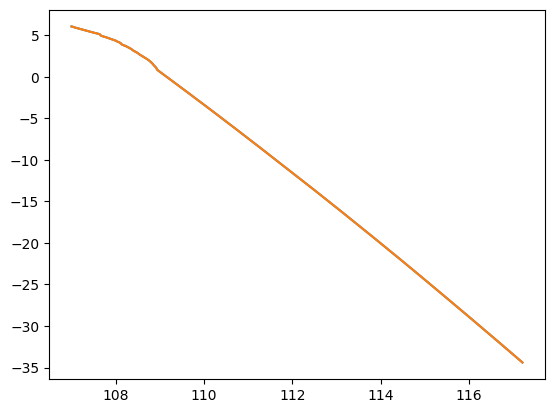

In [5]:
prod = p.z_0-1
plt.plot(model.Vf_W[prod, :, 0], model.Vf_J [prod, :, 0], label='1 senior value function')
plt.plot(model.Vf_W[prod, :, 0], model.Jp[prod, :, 0], label='1 senior value function')  
plt.show()

np.float64(0.029180667059879706)

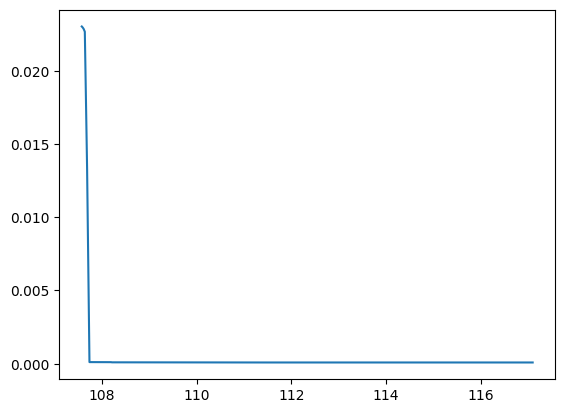

In [9]:
#plt.plot(model.Vf_W[p.z_0-2, :, 0], model.rho_star [p.z_0-2, :, 0], label='1 senior value function')
q=0
prod=p.z_0-0 #soomehow layoffs are higher in high productivity states???
plt.plot(model.Vf_W[prod, :, q], model.sep_star[prod, :, q], label='1 senior value function')  
model.sep_star.mean()

In [2]:
# Load the temp objects
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

# Load the permanent results, for sep, across different parametrizations
with open("results_Rho_sep.pkl", "rb") as file:
    all_results = pickle.load(file)
results = get_results_for_p(p,all_results)

No results found for p = (3, 200, 6, 5, 11, 0.5, 0.5, 5.0, 0.85, 1.0, 1.0)
